In [7]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\spark-2.4.4'

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *
from pyspark.sql.session import SparkSession

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [4]:
users = spark.read.format("csv")\
.options(header = True, inferSchema = True)\
.load("hdfs://localhost:9000/MovieData/input/users.csv")\
.persist()

In [5]:
movies = spark.read.format("csv")\
.options(header = True, inferSchema = True)\
.load("hdfs://localhost:9000/MovieData/input/movie.csv")\
.persist()

In [6]:
ratings = spark.read.format("csv")\
.options(header = True, inferSchema = True)\
.load("hdfs://localhost:9000/MovieData/input/rating.csv")\
.persist()


In [8]:
age_avg_rating = users.alias("t1")\
.join(ratings.alias("t2"), col("t1.user_id") == col("t2.userId"))\
.select(col("rating"), col("age"))\
.groupBy(col("age"))\
.agg(count(col("age")).alias("age_category"), avg("rating").alias("avg_rating")) \
.orderBy(desc("avg_rating"))

In [9]:
age_avg_rating.show()

+--------+------------+------------------+
|     age|age_category|        avg_rating|
+--------+------------+------------------+
|   50-55|       70641|3.5862954941181466|
|   18-24|      159607| 3.538341050204565|
|   35-44|      180083|3.5352143178423283|
|   45-49|       85968|3.5168492927600967|
|Under 18|       34969|3.5156710229060026|
|   25-34|      314284| 3.514257805042573|
|     56+|       55696|3.4560830221200805|
+--------+------------+------------------+



In [40]:
age_avg_rating.coalesce(1).write.csv("hdfs://localhost:9000/MovieData/output/average_rating_age.csv")

In [41]:
age_avg_rating.printSchema()

root
 |-- age: string (nullable = true)
 |-- age_category: long (nullable = false)
 |-- avg_rating: double (nullable = true)



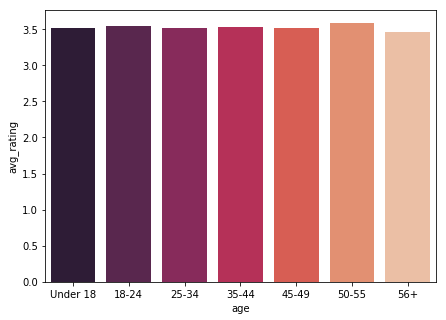

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline 

plt.figure(figsize=(7, 5))

df = age_avg_rating.toPandas()
sb.barplot(data = df, x = 'age', y = 'avg_rating', ci = None, palette = 'rocket', order = ["Under 18", "18-24", "25-34", "35-44", "45-49", "50-55", "56+"]);

In [10]:
age_profession_avg_rating = users.alias("t1")\
.join(ratings.alias("t2"), col("t1.user_id") == col("t2.userId"))\
.select(col("rating"), col("occupation"))\
.groupBy(col("occupation"))\
.agg(count(col("occupation")).alias("category"), avg("rating").alias("avg_rating")) \
.orderBy(desc("avg_rating"))

In [11]:
age_profession_avg_rating.show()

+--------------------+--------+------------------+
|          occupation|category|        avg_rating|
+--------------------+--------+------------------+
|              farmer|    3094|3.6872979961215253|
|          unemployed|   10658| 3.678692062300619|
|              artist|   35857| 3.609239479041749|
|       self-employed|   33323|3.6032320019205955|
|              writer|   33616|3.5818955259400287|
|      clerical/admin|   23156|3.5788132665399894|
|   academic/educator|   71038|3.5780286607167993|
|               other|  105715|3.5483706191174385|
|        K-12 student|   28282|3.5443921929142213|
| tradesman/craftsman|    9382|3.5369857173310595|
|executive/managerial|  101014| 3.535757419763597|
|              lawyer|   19581| 3.522394157601757|
| technician/engineer|   85038| 3.522007808273948|
|college/grad student|  110429|3.5194061342582112|
|          programmer|   62103| 3.498116033041882|
|  doctor/health care|   39845| 3.490450495670724|
|     sales/marketing|   45809|

In [71]:
age_profession_avg_rating.coalesce(1).write.csv("hdfs://localhost:9000/MovieData/output/average_rating_profession.csv")

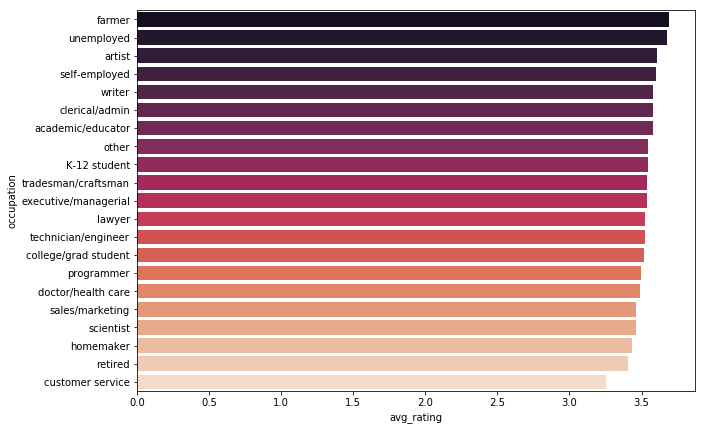

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline 

plt.figure(figsize=(10, 7))

df = age_profession_avg_rating.toPandas()
sb.barplot(data = df, x = 'avg_rating', y = 'occupation', ci = None, palette = 'rocket');

In [61]:
from pyspark.sql.functions import split, explode

age_genres_avg_rating = users.alias("t1")\
.join(ratings.alias("t2"), col("t1.user_id") == col("t2.userId"))\
.join(movies.alias("t3"), col("t2.movieId") == col("t3.movieId"))\
.select(explode(split(col("genres"), "\\|")).alias("genres"), col("age"), col("rating"))\
.groupBy(col("age"), col("genres"))\
.agg(count(col("age")).alias("age_category"), count(col("genres")).alias("genres_category"), avg("rating").alias("avg_rating")) \
.orderBy(desc("avg_rating"))

In [62]:
age_genres_avg_rating.show()

+--------+------------------+------------+---------------+------------------+
|     age|            genres|age_category|genres_category|        avg_rating|
+--------+------------------+------------+---------------+------------------+
|   45-49|(no genres listed)|           1|              1|               4.5|
|   50-55|         Film-Noir|         795|            795| 3.993081761006289|
|   25-34|         Film-Noir|        3522|           3522| 3.989068710959682|
|     56+|         Film-Noir|         549|            549|3.9799635701275045|
|   18-24|         Film-Noir|        1686|           1686| 3.974199288256228|
|   35-44|         Film-Noir|        1966|           1966| 3.950915564598169|
|   50-55|               War|        3781|           3781|3.8841576302565457|
|Under 18|         Film-Noir|         318|            318|3.8726415094339623|
|   50-55|       Documentary|         925|            925|3.8567567567567567|
|Under 18|       Documentary|         460|            460|3.8434